<a href="https://colab.research.google.com/github/sunflowersunflower/NCAA/blob/master/NCAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import math
import csv
import random
import numpy
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [0]:
#@title calculate elo score 
def calc_elo(win_team, lose_team, season):
    winner_rank = get_elo(season, win_team)
    loser_rank = get_elo(season, lose_team)
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff

    return new_winner_rank, new_loser_rank
  
  
def get_elo(season, team):
    try:
        return team_elos[season][team]
    except:
        try:
            # Get the previous season's ending value.
            team_elos[season][team] = team_elos[season-1][team]
            return team_elos[season][team]
        except:
            # Get the starter elo.
            team_elos[season][team] = base_elo
            return team_elos[season][team]

In [0]:
#@title build data 

def initialize_data():
    for i in range(1985, prediction_year+1):
        team_elos[i] = {}
        team_stats[i] = {}

def update_stats(season, team, fields):
    if team not in team_stats[season]:
        team_stats[season][team] = {}

    for key, value in fields.items():
        # Make sure we have the field.
        if key not in team_stats[season][team]:
            team_stats[season][team][key] = []
        if len(team_stats[season][team][key]) >= 9:
            team_stats[season][team][key].pop()
        team_stats[season][team][key].append(value)
        
def get_stat(season, team, field):
    try:
        l = team_stats[season][team][field]
        return sum(l) / float(len(l))
    except:
        return 0
      
def build_team_dict():
    team_ids = pd.read_csv(folder + '/Teams.csv')
    team_id_map = {}
    for index, row in team_ids.iterrows():
        team_id_map[row['Team_Id']] = row['Team_Name']
    return team_id_map
  
def build_season_data(all_data):
    # Calculate the elo for every game for every team, each season.
    # Store the elo per season so we can retrieve their end elo
    # later in order to predict the tournaments without having to
    # inject the prediction into this loop.
    print("Building season data.")
    for index, row in all_data.iterrows():
        # Used to skip matchups where we don't have usable stats yet.
        skip = 0

        # Get starter or previous elos.
        team_1_elo = get_elo(row['Season'], row['Wteam'])
        team_2_elo = get_elo(row['Season'], row['Lteam'])

        if row['Wloc'] == 'H':
            team_1_elo += 100
        elif row['Wloc'] == 'A':
            team_2_elo += 100

        team_1_features = [team_1_elo]
        team_2_features = [team_2_elo]

        for field in stat_fields:
            team_1_stat = get_stat(row['Season'], row['Wteam'], field)
            team_2_stat = get_stat(row['Season'], row['Lteam'], field)
            if team_1_stat is not 0 and team_2_stat is not 0:
                team_1_features.append(team_1_stat)
                team_2_features.append(team_2_stat)
            else:
                skip = 1

        if skip == 0:  # Make sure we have stats.
            # Randomly select left and right and 0 or 1
            if random.random() > 0.5:
                X.append(team_1_features + team_2_features)
                y.append(0)
            else:
                X.append(team_2_features + team_1_features)
                y.append(1)

        if row['Wfta'] != 0 and row['Lfta'] != 0:
            stat_1_fields = {
                'score': row['Wscore'],
                'fgp': row['Wfgm'] / row['Wfga'] * 100,
                'fga': row['Wfga'],
                'fga3': row['Wfga3'],
                '3pp': row['Wfgm3'] / row['Wfga3'] * 100,
                'ftp': row['Wftm'] / row['Wfta'] * 100,
                'or': row['Wor'],
                'dr': row['Wdr'],
                'ast': row['Wast'],
                'to': row['Wto'],
                'stl': row['Wstl'],
                'blk': row['Wblk'],
                'pf': row['Wpf']
            }
            stat_2_fields = {
                'score': row['Lscore'],
                'fgp': row['Lfgm'] / row['Lfga'] * 100,
                'fga': row['Lfga'],
                'fga3': row['Lfga3'],
                '3pp': row['Lfgm3'] / row['Lfga3'] * 100,
                'ftp': row['Lftm'] / row['Lfta'] * 100,
                'or': row['Lor'],
                'dr': row['Ldr'],
                'ast': row['Last'],
                'to': row['Lto'],
                'stl': row['Lstl'],
                'blk': row['Lblk'],
                'pf': row['Lpf']
            }
            update_stats(row['Season'], row['Wteam'], stat_1_fields)
            update_stats(row['Season'], row['Lteam'], stat_2_fields)

        # Now that we've added them, calc the new elo.
        new_winner_rank, new_loser_rank = calc_elo(
            row['Wteam'], row['Lteam'], row['Season'])
        team_elos[row['Season']][row['Wteam']] = new_winner_rank
        team_elos[row['Season']][row['Lteam']] = new_loser_rank

    return X, y

In [0]:
#@title prediction of result 
def predict_winner(team_1, team_2, model, season, stat_fields):
    features = []

    # Team 1
    features.append(get_elo(season, team_1))
    for stat in stat_fields:
        features.append(get_stat(season, team_1, stat))

    # Team 2
    features.append(get_elo(season, team_2))
    for stat in stat_fields:
        features.append(get_stat(season, team_2, stat))

    return model.predict_proba([features])

In [0]:
#@title helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [0]:
#@title load data 
file_id='1PVdFEP4YXHdQ8vc-Vi75roecxhcBc1D1'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url=link.format(FILE_ID=file_id)
season_data = pd.read_csv(csv_url)

file_id='11w8bD8Pm1LMIvc7Cu3V63FFxjfEP5Jd0'
link='https://drive.google.com/uc?export=download&id={FILE_ID}'
csv_url=link.format(FILE_ID=file_id)
tourney_data = pd.read_csv(csv_url)



In [0]:
base_elo = 1600
team_elos = {}  
team_stats = {}
X = []
y = []
prediction_year = 2016

In [0]:
if __name__ == "__main__":
    stat_fields = ['score', 'fga', 'fgp', 'fga3', '3pp', 'ftp', 'or', 'dr',
                   'ast', 'to', 'stl', 'blk', 'pf']
    initialize_data()
    frames = [season_data, tourney_data]
    all_data = pd.concat(frames)

    # Build the working data.
    X, y = build_season_data(all_data)


Building season data.


In [0]:
X_data = pd.DataFrame(X, columns = ['Elo'] + stat_fields + ['Elo'] + stat_fields)
y_data = pd.DataFrame(y, columns = ['win'])

In [0]:
X_data.head()

,Elo,score,fga,fgp,fga3,3pp,ftp,or,dr,ast,to,stl,blk,pf,Elo,score,fga,fgp,fga3,3pp,ftp,or,dr,ast,to,stl,blk,pf
0,1584,50.0,49.0,36.734694,22.0,27.272727,53.333333,17.0,20.0,9.0,19.0,4.0,3.0,23.0,1584,55.0,46.0,43.478261,11.0,27.272727,70.588235,6.0,22.0,8.0,19.0,4.0,3.0,25.0
1,1616,56.0,38.0,47.368421,9.0,33.333333,54.838710,6.0,19.0,11.0,12.0,14.0,2.0,18.0,1716,81.0,57.0,45.614035,12.0,50.000000,85.185185,12.0,24.0,12.0,9.0,9.0,3.0,18.0
2,1584,48.0,64.0,28.125000,24.0,33.333333,50.000000,14.0,26.0,12.0,17.0,10.0,0.0,17.0,1584,65.0,56.0,42.857143,19.0,31.578947,64.705882,14.0,21.0,17.0,18.0,8.0,4.0,13.0
3,1584,62.0,41.0,46.341463,15.0,26.666667,71.428571,9.0,21.0,11.0,30.0,10.0,4.0,28.0,1584,66.0,52.0,46.153846,18.0,33.333333,44.444444,13.0,26.0,13.0,25.0,8.0,2.0,18.0
4,1716,80.0,55.0,41.818182,8.0,25.000000,82.051282,13.0,18.0,14.0,17.0,11.0,1.0,25.0,1616,71.0,58.0,48.275862,11.0,45.454545,55.555556,9.0,22.0,9.0,17.0,9.0,2.0,23.0


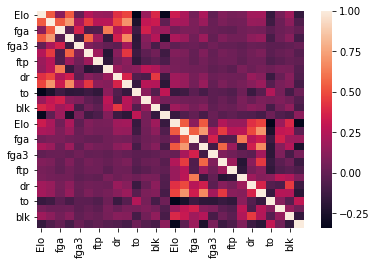

In [0]:
corr = X_data.corr()
sns.heatmap(corr)

**Model Training**

Split dataset

In [3]:
# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

NameError: ignored

In [0]:
# Scale the data, using standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Model Training and Selection

In [0]:
#@title build models

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

In [0]:
# Train the model
classifier_logistic.fit(X_train, y_train)
# Prediction of test data
classifier_logistic.predict(X_test)
# Accuracy of test data
classifier_logistic.score(X_test, y_test)

0.731545079892994

In [0]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, numpy.array(X), numpy.array(y), cv=5)
    # cprint(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1

Model accuracy of Logistic Regression is: 0.727
Model accuracy of KNN is: 0.683
Model accuracy of Random Forest is: 0.678


Find Optimal Hyperparameters - LogisticRegression

In [0]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(numpy.array(X), numpy.array(y))
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.727
Best parameters set:
	C: 0.1
	penalty: 'l2'


In [0]:
# best model
best_LR_model = Grid_LR.best_estimator_

Find Optimal Hyperparameters: KNN

In [0]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)
print_grid_search_metrics(Grid_KNN)

Best score: 0.665
Best parameters set:
	n_neighbors: 10


 Find Optimal Hyperparameters: Random Forest

In [0]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)
# best number of tress
print_grid_search_metrics(Grid_RF)


Best score: 0.715
Best parameters set:
	n_estimators: 80


In [0]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

In [0]:
#@title helper function for confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [2]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

NameError: ignored

Model Evaluation - ROC & AUC

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

In [0]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [0]:
# AUC score
metrics.auc(fpr_rf,tpr_rf)

In [0]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

In [0]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [0]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

Random Forest Model - Feature Importance Discussion

In [0]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")    #round(number, number of digits)
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat_space.columns), reverse=True):
    print (v + ": " + str(k))